# PHÂN TÍCH DỮ LIỆU BÓNG ĐÁ QUỐC TẾ - TẬP TRUNG VÀO ĐỘI TUYỂN VIỆT NAM

# CHƯƠNG 1: TỔNG QUAN

## 1.1 Giới thiệu bài toán

Bóng đá là môn thể thao phổ biến nhất thế giới và có tầm quan trọng đặc biệt đối với Việt Nam. Việc phân tích dữ liệu bóng đá quốc tế, đặc biệt tập trung vào đội tuyển Việt Nam, có thể giúp:

- **Hiểu rõ phong độ** của đội tuyển qua các giai đoạn khác nhau
- **Phân tích đối thủ** để xây dựng chiến thuật phù hợp  
- **Dự đoán kết quả** trận đấu dựa trên các yếu tố lịch sử
- **Đánh giá hiệu quả** của các giai đoạn huấn luyện viên

## 1.2 Mục tiêu dự án

1. **Phân tích phong độ đội tuyển Việt Nam (2000–nay)**
   - Thống kê số trận, bàn thắng/bàn thua, tỉ lệ thắng–hòa–thua theo năm
   - So sánh trước/sau thời kỳ HLV Park Hang-seo (2017–2022)

2. **Phân cụm (Clustering) theo giai đoạn HLV**
   - Tạo feature theo từng giai đoạn HLV: trung bình bàn thắng, bàn thua, win rate
   - Gom cụm để thấy sự khác biệt phong độ giữa các giai đoạn

3. **Phân cụm đối thủ của Việt Nam**
   - Feature: số trận gặp, tỉ lệ thắng, bàn thắng/bàn thua trung bình
   - Gom cụm để phân nhóm đối thủ: "khắc tinh", "ngang cơ", "yếu hơn"

4. **Classification – Dự đoán kết quả trận (Win/Draw/Lose)**
   - Sử dụng Decision Tree, Random Forest, Logistic Regression
   - Đánh giá bằng Accuracy, Precision, Recall, F1-score


## 1.3 Mô tả bộ dữ liệu

### Nguồn gốc dữ liệu:
- **Dataset**: International Football Results from 1872 to 2024
- **Nguồn**: Github https://github.com/martj42/international_results
- **Thời gian**: Từ năm 1872 đến 2024 (lọc từ 2000 trở đi)

### Cấu trúc dữ liệu:

####  **results.csv** (48,366 trận đấu)
- `date`: Ngày thi đấu
- `home_team`: Đội chủ nhà
- `away_team`: Đội khách  
- `home_score`: Số bàn thắng đội chủ nhà
- `away_score`: Số bàn thắng đội khách
- `tournament`: Tên giải đấu
- `city`: Thành phố tổ chức
- `country`: Quốc gia tổ chức
- `neutral`: Sân trung lập (True/False)

####  **goalscorers.csv** (44,447 bàn thắng)
- `date`, `home_team`, `away_team`: Thông tin trận đấu
- `team`: Đội ghi bàn
- `scorer`: Tên cầu thủ ghi bàn
- `own_goal`: Bàn phản lưới nhà (True/False)
- `penalty`: Bàn phạt đền (True/False)

####  **shootouts.csv** (650 trận penalty)
- `date`, `home_team`, `away_team`: Thông tin trận đấu
- `winner`: Đội thắng penalty
- `first_shooter`: Đội đá phạt đầu tiên

### Ý nghĩa các thuộc tính:
- **Kết quả trận đấu**: Phản ánh phong độ và sức mạnh tương đối
- **Giải đấu**: Mức độ quan trọng và cạnh tranh
- **Venue**: Lợi thế sân nhà/khách
- **Thời gian**: Xu hướng phát triển theo năm


# CHƯƠNG 2: TIỀN XỬ LÝ DỮ LIỆU

## 2.1 Import thư viện và tải dữ liệu


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, silhouette_score

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ Thư viện đã được import thành công!")


✅ Thư viện đã được import thành công!


In [2]:
# Tải dữ liệu từ thư mục dataset
try:
    results_df = pd.read_csv('dataset/results.csv')
    goalscorers_df = pd.read_csv('dataset/goalscorers.csv')
    shootouts_df = pd.read_csv('dataset/shootouts.csv')
    
    print("📊 THÔNG TIN DỮ LIỆU GỐC:")
    print(f"Results: {results_df.shape[0]:,} trận đấu, {results_df.shape[1]} thuộc tính")
    print(f"Goalscorers: {goalscorers_df.shape[0]:,} bàn thắng, {goalscorers_df.shape[1]} thuộc tính")
    print(f"Shootouts: {shootouts_df.shape[0]:,} trận penalty, {shootouts_df.shape[1]} thuộc tính")
    
    print("\n📋 CẤU TRÚC DỮ LIỆU RESULTS:")
    print(results_df.info())
    
except FileNotFoundError as e:
    print(f"❌ Lỗi: Không tìm thấy file dữ liệu: {e}")
    print("Vui lòng đảm bảo thư mục 'dataset' có chứa các file CSV")
    results_df = None
    goalscorers_df = None
    shootouts_df = None


📊 THÔNG TIN DỮ LIỆU GỐC:
Results: 48,366 trận đấu, 9 thuộc tính
Goalscorers: 44,447 bàn thắng, 8 thuộc tính
Shootouts: 650 trận penalty, 5 thuộc tính

📋 CẤU TRÚC DỮ LIỆU RESULTS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48366 entries, 0 to 48365
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        48366 non-null  object
 1   home_team   48366 non-null  object
 2   away_team   48366 non-null  object
 3   home_score  48366 non-null  int64 
 4   away_score  48366 non-null  int64 
 5   tournament  48366 non-null  object
 6   city        48366 non-null  object
 7   country     48366 non-null  object
 8   neutral     48366 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 3.0+ MB
None


## 2.2 Làm sạch dữ liệu (Data Cleaning)

### 2.2.1 Xử lý Missing Values và Outliers


In [3]:
if results_df is not None:
    # Kiểm tra missing values
    print("🔍 KIỂM TRA MISSING VALUES:")
    missing_values = results_df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # Kiểm tra outliers trong điểm số
    print("\n📊 PHÂN TÍCH OUTLIERS TRONG ĐIỂM SỐ:")
    print(f"Home score - Min: {results_df['home_score'].min()}, Max: {results_df['home_score'].max()}")
    print(f"Away score - Min: {results_df['away_score'].min()}, Max: {results_df['away_score'].max()}")
    
    # Kiểm tra các trận có điểm số bất thường (>10 bàn)
    high_scores = results_df[(results_df['home_score'] > 10) | (results_df['away_score'] > 10)]
    print(f"\n⚠️ Số trận có điểm số > 10: {len(high_scores)}")
    if len(high_scores) > 0:
        print("Một số trận có điểm số cao:")
        print(high_scores[['date', 'home_team', 'away_team', 'home_score', 'away_score']].head())
    
    # Chuyển đổi date sang datetime
    results_df['date'] = pd.to_datetime(results_df['date'])
    goalscorers_df['date'] = pd.to_datetime(goalscorers_df['date'])
    shootouts_df['date'] = pd.to_datetime(shootouts_df['date'])
    
    print("\n✅ Dữ liệu đã được làm sạch cơ bản!")
else:
    print("❌ Không có dữ liệu để xử lý")


🔍 KIỂM TRA MISSING VALUES:
Series([], dtype: int64)

📊 PHÂN TÍCH OUTLIERS TRONG ĐIỂM SỐ:
Home score - Min: 0, Max: 31
Away score - Min: 0, Max: 21

⚠️ Số trận có điểm số > 10: 199
Một số trận có điểm số cao:
           date         home_team         away_team  home_score  away_score
19   1882-02-18  Northern Ireland           England           0          13
56   1888-03-03             Wales  Northern Ireland          11           0
121  1899-02-18           England  Northern Ireland          13           2
133  1901-02-23          Scotland  Northern Ireland          11           0
230  1908-06-08           Austria           England           1          11

✅ Dữ liệu đã được làm sạch cơ bản!


### 2.2.2 Lọc dữ liệu Việt Nam và tạo features

**Lý do lựa chọn kỹ thuật:**
- Lọc từ năm 2000: Dữ liệu gần đây hơn, phù hợp với mục tiêu phân tích
- Chuẩn hóa tên đội: Đảm bảo tính nhất quán trong phân tích
- Tạo features mới: Cần thiết cho các thuật toán machine learning


In [4]:
if results_df is not None:
    # Lọc dữ liệu từ năm 2000 trở đi
    results_df = results_df[results_df['date'].dt.year >= 2000]
    goalscorers_df = goalscorers_df[goalscorers_df['date'].dt.year >= 2000]
    shootouts_df = shootouts_df[shootouts_df['date'].dt.year >= 2000]
    
    print(f"📅 DỮ LIỆU SAU KHI LỌC TỪ NĂM 2000:")
    print(f"Results: {results_df.shape[0]:,} trận đấu")
    print(f"Goalscorers: {goalscorers_df.shape[0]:,} bàn thắng")
    print(f"Shootouts: {shootouts_df.shape[0]:,} trận penalty")
    
    # Tìm các trận đấu có Việt Nam tham gia
    vietnam_matches = results_df[
        (results_df['home_team'].str.contains('Vietnam', case=False, na=False)) |
        (results_df['away_team'].str.contains('Vietnam', case=False, na=False))
    ].copy()
    
    print(f"\n🇻🇳 SỐ TRẬN ĐẤU CÓ VIỆT NAM THAM GIA: {len(vietnam_matches)}")
    
    if len(vietnam_matches) > 0:
        print(f"Từ năm {vietnam_matches['date'].min().year} đến {vietnam_matches['date'].max().year}")
        
        # Chuẩn hóa tên đội
        vietnam_matches['home_team'] = vietnam_matches['home_team'].replace({
            'Vietnam': 'Vietnam',
            'Viet Nam': 'Vietnam'
        })
        vietnam_matches['away_team'] = vietnam_matches['away_team'].replace({
            'Vietnam': 'Vietnam',
            'Viet Nam': 'Vietnam'
        })
        
        print("✅ Tên đội đã được chuẩn hóa!")
    else:
        print("❌ Không tìm thấy trận đấu nào có Việt Nam tham gia")
        vietnam_matches = None
else:
    print("❌ Không có dữ liệu để xử lý")
    vietnam_matches = None


📅 DỮ LIỆU SAU KHI LỌC TỪ NĂM 2000:
Results: 24,310 trận đấu
Goalscorers: 25,245 bàn thắng
Shootouts: 388 trận penalty

🇻🇳 SỐ TRẬN ĐẤU CÓ VIỆT NAM THAM GIA: 230
Từ năm 2000 đến 2025
✅ Tên đội đã được chuẩn hóa!


In [5]:
if vietnam_matches is not None and len(vietnam_matches) > 0:
    # Tạo cột kết quả cho Việt Nam
    def get_vietnam_result(row):
        if row['home_team'] == 'Vietnam':
            if row['home_score'] > row['away_score']:
                return 'win'
            elif row['home_score'] == row['away_score']:
                return 'draw'
            else:
                return 'lose'
        else:  # away_team == 'Vietnam'
            if row['away_score'] > row['home_score']:
                return 'win'
            elif row['away_score'] == row['home_score']:
                return 'draw'
            else:
                return 'lose'
    
    # Tạo các features mới
    vietnam_matches['result'] = vietnam_matches.apply(get_vietnam_result, axis=1)
    vietnam_matches['opponent'] = vietnam_matches.apply(
        lambda row: row['away_team'] if row['home_team'] == 'Vietnam' else row['home_team'],
        axis=1
    )
    vietnam_matches['venue'] = vietnam_matches.apply(
        lambda row: 'home' if row['home_team'] == 'Vietnam' else 'away',
        axis=1
    )
    vietnam_matches['goals_scored'] = vietnam_matches.apply(
        lambda row: row['home_score'] if row['home_team'] == 'Vietnam' else row['away_score'],
        axis=1
    )
    vietnam_matches['goals_conceded'] = vietnam_matches.apply(
        lambda row: row['away_score'] if row['home_team'] == 'Vietnam' else row['home_score'],
        axis=1
    )
    vietnam_matches['goal_diff'] = vietnam_matches['goals_scored'] - vietnam_matches['goals_conceded']
    
    # Tạo feature năm
    vietnam_matches['year'] = vietnam_matches['date'].dt.year
    
    print("🎯 CÁC FEATURES MỚI ĐÃ ĐƯỢC TẠO:")
    print("✅ result: Kết quả trận đấu (win/draw/lose)")
    print("✅ opponent: Đối thủ của Việt Nam")
    print("✅ venue: Sân đấu (home/away)")
    print("✅ goals_scored: Bàn thắng Việt Nam ghi được")
    print("✅ goals_conceded: Bàn thua Việt Nam để thủng lưới")
    print("✅ goal_diff: Hiệu số bàn thắng")
    print("✅ year: Năm thi đấu")
    
    print(f"\n📊 THỐNG KÊ CƠ BẢN:")
    print(f"Tổng số trận: {len(vietnam_matches)}")
    print(f"Tỷ lệ thắng: {len(vietnam_matches[vietnam_matches['result'] == 'win']) / len(vietnam_matches):.3f}")
    print(f"Tỷ lệ hòa: {len(vietnam_matches[vietnam_matches['result'] == 'draw']) / len(vietnam_matches):.3f}")
    print(f"Tỷ lệ thua: {len(vietnam_matches[vietnam_matches['result'] == 'lose']) / len(vietnam_matches):.3f}")
    
    print(f"\n📈 BÀN THẮNG TRUNG BÌNH:")
    print(f"Bàn thắng/trận: {vietnam_matches['goals_scored'].mean():.2f}")
    print(f"Bàn thua/trận: {vietnam_matches['goals_conceded'].mean():.2f}")
    print(f"Hiệu số bàn thắng: {vietnam_matches['goal_diff'].mean():.2f}")
    
else:
    print("❌ Không có dữ liệu Việt Nam để tạo features")


🎯 CÁC FEATURES MỚI ĐÃ ĐƯỢC TẠO:
✅ result: Kết quả trận đấu (win/draw/lose)
✅ opponent: Đối thủ của Việt Nam
✅ venue: Sân đấu (home/away)
✅ goals_scored: Bàn thắng Việt Nam ghi được
✅ goals_conceded: Bàn thua Việt Nam để thủng lưới
✅ goal_diff: Hiệu số bàn thắng
✅ year: Năm thi đấu

📊 THỐNG KÊ CƠ BẢN:
Tổng số trận: 230
Tỷ lệ thắng: 0.435
Tỷ lệ hòa: 0.222
Tỷ lệ thua: 0.343

📈 BÀN THẮNG TRUNG BÌNH:
Bàn thắng/trận: 1.70
Bàn thua/trận: 1.30
Hiệu số bàn thắng: 0.40


# CHƯƠNG 3: ÁP DỤNG CÁC MÔ HÌNH KHAI PHÁ DỮ LIỆU

## 3.1 Phân cụm theo giai đoạn HLV (K-Means Clustering)

### 3.1.1 Cơ sở lý thuyết K-Means

**K-Means** là thuật toán phân cụm không giám sát, hoạt động theo nguyên lý:
1. Chọn k điểm trung tâm ban đầu (centroids)
2. Gán mỗi điểm dữ liệu vào cluster gần nhất
3. Cập nhật vị trí centroids dựa trên trung bình của các điểm trong cluster
4. Lặp lại cho đến khi hội tụ

**Lý do lựa chọn:** Phù hợp để phân nhóm các giai đoạn HLV dựa trên các chỉ số hiệu suất tương tự nhau.

### 3.1.2 Tạo features cho clustering


In [6]:
if vietnam_matches is not None and len(vietnam_matches) > 0:
    # Phân chia theo giai đoạn HLV
    def get_coach_period(date):
        year = date.year
        if year < 2017:
            return 'Trước Park Hang-seo (2000-2016)'
        elif year <= 2022:
            return 'Park Hang-seo (2017-2022)'
        else:
            return 'Sau Park Hang-seo (2023-nay)'
    
    vietnam_matches['coach_period'] = vietnam_matches['date'].apply(get_coach_period)
    
    # Tạo features cho clustering theo giai đoạn HLV
    coach_features = vietnam_matches.groupby('coach_period').agg({
        'result': 'count',
        'goals_scored': 'sum',
        'goals_conceded': 'sum',
        'goal_diff': 'sum'
    }).rename(columns={'result': 'total_matches'})
    
    # Tính tỷ lệ thắng và các chỉ số trung bình
    for period in coach_features.index:
        period_matches = vietnam_matches[vietnam_matches['coach_period'] == period]
        wins = len(period_matches[period_matches['result'] == 'win'])
        total = len(period_matches)
        coach_features.loc[period, 'win_rate'] = wins / total if total > 0 else 0
        coach_features.loc[period, 'avg_goals_scored'] = period_matches['goals_scored'].mean()
        coach_features.loc[period, 'avg_goals_conceded'] = period_matches['goals_conceded'].mean()
        coach_features.loc[period, 'avg_goal_diff'] = period_matches['goal_diff'].mean()
    
    print("📊 FEATURES CHO CLUSTERING GIAI ĐOẠN HLV:")
    print(coach_features.round(3))
    
    # Chuẩn bị dữ liệu cho K-Means
    clustering_features = ['win_rate', 'avg_goals_scored', 'avg_goals_conceded', 'avg_goal_diff']
    X_coach = coach_features[clustering_features].copy()
    
    print(f"\n🎯 DỮ LIỆU CHO CLUSTERING:")
    print(f"Số giai đoạn: {len(X_coach)}")
    print(f"Số features: {len(clustering_features)}")
    print("Features:", clustering_features)
    
else:
    print("❌ Không có dữ liệu để tạo features clustering")


📊 FEATURES CHO CLUSTERING GIAI ĐOẠN HLV:
                                 total_matches  goals_scored  goals_conceded  \
coach_period                                                                   
Park Hang-seo (2017-2022)                   54            85              45   
Sau Park Hang-seo (2023-nay)                35            52              50   
Trước Park Hang-seo (2000-2016)            141           254             204   

                                 goal_diff  win_rate  avg_goals_scored  \
coach_period                                                             
Park Hang-seo (2017-2022)               40     0.463             1.574   
Sau Park Hang-seo (2023-nay)             2     0.457             1.486   
Trước Park Hang-seo (2000-2016)         50     0.418             1.801   

                                 avg_goals_conceded  avg_goal_diff  
coach_period                                                        
Park Hang-seo (2017-2022)                     0.8

### 3.1.3 Elbow Method để xác định số cluster tối ưu


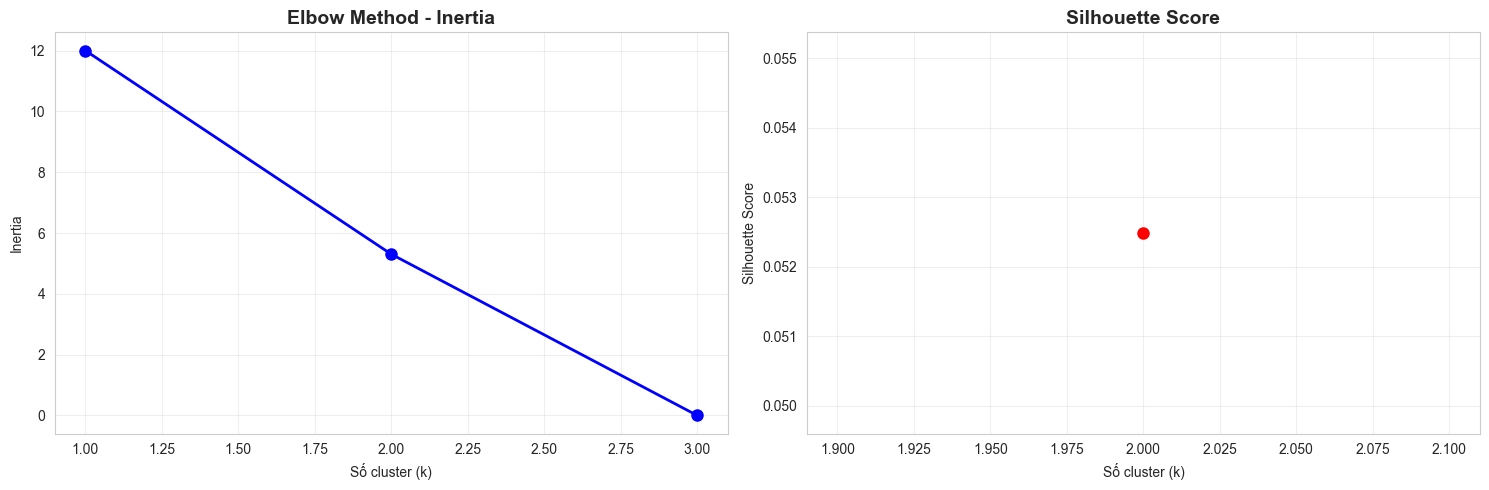

🎯 SỐ CLUSTER TỐI ƯU: 2
Silhouette Score cao nhất: 0.052

📊 KẾT QUẢ CLUSTERING GIAI ĐOẠN HLV:
                                 win_rate  avg_goals_scored  \
coach_period                                                  
Park Hang-seo (2017-2022)           0.463             1.574   
Sau Park Hang-seo (2023-nay)        0.457             1.486   
Trước Park Hang-seo (2000-2016)     0.418             1.801   

                                 avg_goals_conceded  avg_goal_diff  \
coach_period                                                         
Park Hang-seo (2017-2022)                     0.833          0.741   
Sau Park Hang-seo (2023-nay)                  1.429          0.057   
Trước Park Hang-seo (2000-2016)               1.447          0.355   

                                cluster_name  
coach_period                                  
Park Hang-seo (2017-2022)         Trung bình  
Sau Park Hang-seo (2023-nay)      Trung bình  
Trước Park Hang-seo (2000-2016)   Trung bình  


In [7]:
if 'X_coach' in locals() and len(X_coach) > 0:
    # Elbow Method để xác định số cluster tối ưu
    from sklearn.preprocessing import StandardScaler
    
    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_coach_scaled = scaler.fit_transform(X_coach)
    
    # Thử các giá trị k từ 1 đến min(5, số giai đoạn)
    max_k = min(5, len(X_coach))
    k_range = range(1, max_k + 1)
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_coach_scaled)
        inertias.append(kmeans.inertia_)
        
        # Silhouette score chỉ tính được khi k > 1 và k < số mẫu
        if k > 1 and k < len(X_coach):
            try:
                silhouette_scores.append(silhouette_score(X_coach_scaled, kmeans.labels_))
            except ValueError:
                silhouette_scores.append(0)
        else:
            silhouette_scores.append(0)
    
    # Vẽ biểu đồ Elbow Method
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.title('Elbow Method - Inertia', fontsize=14, fontweight='bold')
    plt.xlabel('Số cluster (k)')
    plt.ylabel('Inertia')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    valid_k = [k for k in k_range if k > 1 and k < len(X_coach)]
    valid_scores = [silhouette_scores[i-1] for i in valid_k]
    if valid_scores:
        plt.plot(valid_k, valid_scores, 'ro-', linewidth=2, markersize=8)
        plt.title('Silhouette Score', fontsize=14, fontweight='bold')
        plt.xlabel('Số cluster (k)')
        plt.ylabel('Silhouette Score')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Không thể tính Silhouette Score\nvới dữ liệu hiện tại', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Silhouette Score', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Xác định k tối ưu
    if valid_scores:
        optimal_k = valid_k[np.argmax(valid_scores)]
        print(f"🎯 SỐ CLUSTER TỐI ƯU: {optimal_k}")
        print(f"Silhouette Score cao nhất: {max(valid_scores):.3f}")
    else:
        # Nếu không thể tính silhouette score, sử dụng k=2
        optimal_k = 2
        print(f"🎯 SỬ DỤNG K=2 (không thể tính Silhouette Score)")
    
    # Thực hiện K-Means với k tối ưu
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    coach_clusters = kmeans_optimal.fit_predict(X_coach_scaled)
    
    # Thêm cluster vào dataframe
    coach_features['cluster'] = coach_clusters
    
    # Đặt tên cluster dựa trên win_rate
    cluster_names = {}
    for i in range(optimal_k):
        cluster_data = coach_features[coach_features['cluster'] == i]
        avg_win_rate = cluster_data['win_rate'].mean()
        if avg_win_rate > 0.5:
            cluster_names[i] = 'Mạnh'
        elif avg_win_rate > 0.4:
            cluster_names[i] = 'Trung bình'
        else:
            cluster_names[i] = 'Yếu'
    
    coach_features['cluster_name'] = coach_features['cluster'].map(cluster_names)
    
    print(f"\n📊 KẾT QUẢ CLUSTERING GIAI ĐOẠN HLV:")
    print(coach_features[['win_rate', 'avg_goals_scored', 'avg_goals_conceded', 'avg_goal_diff', 'cluster_name']].round(3))
    
else:
    print("❌ Không có dữ liệu để thực hiện Elbow Method")


## 3.2 Phân cụm đối thủ của Việt Nam

### 3.2.1 Tạo features cho clustering đối thủ

**Lý do lựa chọn:** Phân nhóm đối thủ giúp hiểu rõ hơn về sức mạnh tương đối và xây dựng chiến thuật phù hợp.


In [8]:
if vietnam_matches is not None and len(vietnam_matches) > 0:
    # Tạo features cho clustering đối thủ
    opponent_features = vietnam_matches.groupby('opponent').agg({
        'result': 'count',
        'goals_scored': 'sum',
        'goals_conceded': 'sum',
        'goal_diff': 'sum'
    }).rename(columns={'result': 'total_matches'})
    
    # Tính tỷ lệ thắng và các chỉ số trung bình cho mỗi đối thủ
    for opponent in opponent_features.index:
        opponent_matches = vietnam_matches[vietnam_matches['opponent'] == opponent]
        wins = len(opponent_matches[opponent_matches['result'] == 'win'])
        total = len(opponent_matches)
        opponent_features.loc[opponent, 'win_rate'] = wins / total if total > 0 else 0
        opponent_features.loc[opponent, 'avg_goals_scored'] = opponent_matches['goals_scored'].mean()
        opponent_features.loc[opponent, 'avg_goals_conceded'] = opponent_matches['goals_conceded'].mean()
        opponent_features.loc[opponent, 'avg_goal_diff'] = opponent_matches['goal_diff'].mean()
    
    # Lọc các đối thủ có ít nhất 2 trận đấu để đảm bảo tính đại diện
    opponent_features = opponent_features[opponent_features['total_matches'] >= 2]
    
    print(f"📊 FEATURES CHO CLUSTERING ĐỐI THỦ:")
    print(f"Số đối thủ: {len(opponent_features)}")
    print(f"Top 10 đối thủ gặp nhiều nhất:")
    print(opponent_features.nlargest(10, 'total_matches')[['total_matches', 'win_rate', 'avg_goals_scored', 'avg_goals_conceded']].round(3))
    
    # Chuẩn bị dữ liệu cho clustering đối thủ
    opponent_clustering_features = ['win_rate', 'avg_goals_scored', 'avg_goals_conceded', 'avg_goal_diff']
    X_opponent = opponent_features[opponent_clustering_features].copy()
    
    print(f"\n🎯 DỮ LIỆU CHO CLUSTERING ĐỐI THỦ:")
    print(f"Số đối thủ: {len(X_opponent)}")
    print(f"Số features: {len(opponent_clustering_features)}")
    print("Features:", opponent_clustering_features)
    
else:
    print("❌ Không có dữ liệu để tạo features clustering đối thủ")


📊 FEATURES CHO CLUSTERING ĐỐI THỦ:
Số đối thủ: 35
Top 10 đối thủ gặp nhiều nhất:
             total_matches  win_rate  avg_goals_scored  avg_goals_conceded
opponent                                                                  
Thailand                22     0.136             0.773               1.636
Indonesia               20     0.250             1.250               1.300
Malaysia                20     0.650             1.500               1.050
Singapore               14     0.500             1.500               0.500
Philippines             12     0.750             2.083               1.000
Laos                    11     1.000             4.364               0.091
Myanmar                 10     0.700             3.500               0.800
Cambodia                 9     1.000             4.667               0.667
China PR                 7     0.143             1.000               2.714
Iraq                     7     0.000             0.857               2.000

🎯 DỮ LIỆU CHO CLUS

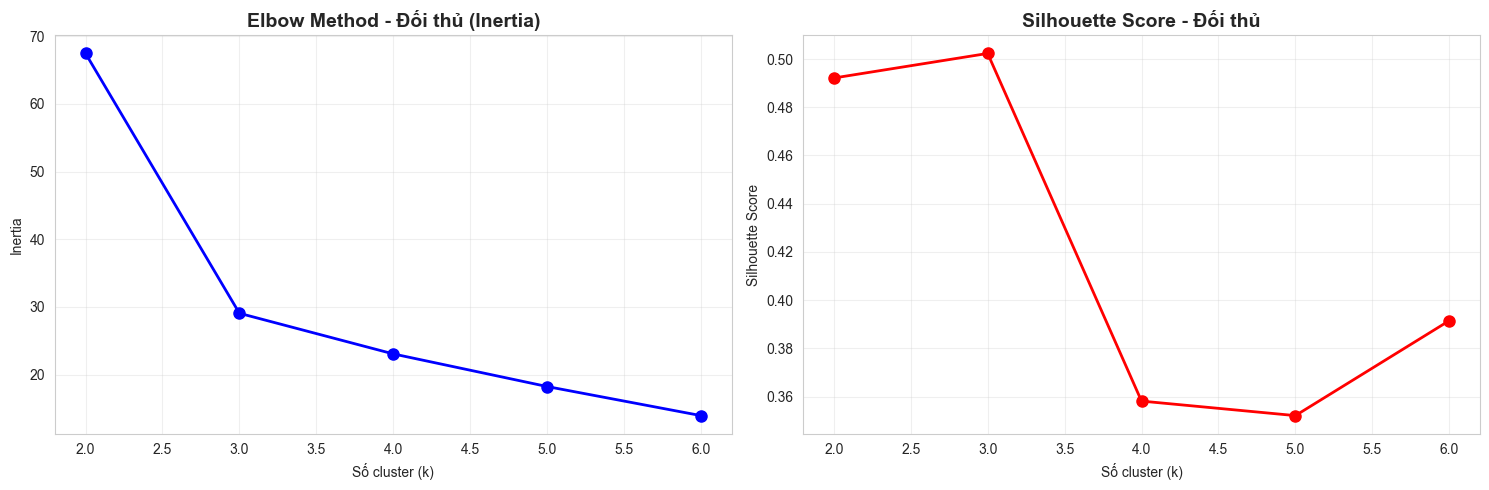

🎯 SỐ CLUSTER TỐI ƯU CHO ĐỐI THỦ: 3
Silhouette Score cao nhất: 0.502

📊 KẾT QUẢ CLUSTERING ĐỐI THỦ:
                      total_matches  win_rate  avg_goals_scored  \
opponent                                                          
Afghanistan                       3     0.333             1.000   
Australia                         2     0.000             0.000   
Bangladesh                        2     0.500             2.000   
Cambodia                          9     1.000             4.667   
China PR                          7     0.143             1.000   
Hong Kong                         6     0.667             1.833   
India                             4     0.500             1.750   
Indonesia                        20     0.250             1.250   
Iraq                              7     0.000             0.857   
Japan                             6     0.000             0.667   
Jordan                            4     0.000             0.750   
Kuwait                        

In [9]:
if 'X_opponent' in locals() and len(X_opponent) > 0:
    # Elbow Method cho clustering đối thủ
    scaler_opponent = StandardScaler()
    X_opponent_scaled = scaler_opponent.fit_transform(X_opponent)
    
    # Thử các giá trị k từ 2 đến min(6, số đối thủ)
    max_k_opponent = min(6, len(X_opponent))
    k_range_opponent = range(2, max_k_opponent + 1)
    inertias_opponent = []
    silhouette_scores_opponent = []
    
    for k in k_range_opponent:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_opponent_scaled)
        inertias_opponent.append(kmeans.inertia_)
        
        # Silhouette score chỉ tính được khi k < số mẫu
        if k < len(X_opponent):
            try:
                silhouette_scores_opponent.append(silhouette_score(X_opponent_scaled, kmeans.labels_))
            except ValueError:
                silhouette_scores_opponent.append(0)
        else:
            silhouette_scores_opponent.append(0)
    
    # Vẽ biểu đồ Elbow Method cho đối thủ
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range_opponent, inertias_opponent, 'bo-', linewidth=2, markersize=8)
    plt.title('Elbow Method - Đối thủ (Inertia)', fontsize=14, fontweight='bold')
    plt.xlabel('Số cluster (k)')
    plt.ylabel('Inertia')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    valid_k_opponent = [k for k in k_range_opponent if k < len(X_opponent)]
    valid_scores_opponent = [silhouette_scores_opponent[i-2] for i in valid_k_opponent]
    if valid_scores_opponent:
        plt.plot(valid_k_opponent, valid_scores_opponent, 'ro-', linewidth=2, markersize=8)
        plt.title('Silhouette Score - Đối thủ', fontsize=14, fontweight='bold')
        plt.xlabel('Số cluster (k)')
        plt.ylabel('Silhouette Score')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Không thể tính Silhouette Score\nvới dữ liệu hiện tại', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Silhouette Score - Đối thủ', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Xác định k tối ưu cho đối thủ
    if valid_scores_opponent:
        optimal_k_opponent = valid_k_opponent[np.argmax(valid_scores_opponent)]
        print(f"🎯 SỐ CLUSTER TỐI ƯU CHO ĐỐI THỦ: {optimal_k_opponent}")
        print(f"Silhouette Score cao nhất: {max(valid_scores_opponent):.3f}")
    else:
        # Nếu không thể tính silhouette score, sử dụng k=2
        optimal_k_opponent = 2
        print(f"🎯 SỬ DỤNG K=2 CHO ĐỐI THỦ (không thể tính Silhouette Score)")
    
    # Thực hiện K-Means cho đối thủ
    kmeans_opponent = KMeans(n_clusters=optimal_k_opponent, random_state=42, n_init=10)
    opponent_clusters = kmeans_opponent.fit_predict(X_opponent_scaled)
    
    # Thêm cluster vào dataframe đối thủ
    opponent_features['cluster'] = opponent_clusters
    
    # Đặt tên cluster dựa trên win_rate
    opponent_cluster_names = {}
    for i in range(optimal_k_opponent):
        cluster_data = opponent_features[opponent_features['cluster'] == i]
        avg_win_rate = cluster_data['win_rate'].mean()
        if avg_win_rate < 0.3:
            opponent_cluster_names[i] = 'Khắc tinh'
        elif avg_win_rate < 0.6:
            opponent_cluster_names[i] = 'Ngang cơ'
        else:
            opponent_cluster_names[i] = 'Yếu hơn'
    
    opponent_features['cluster_name'] = opponent_features['cluster'].map(opponent_cluster_names)
    
    print(f"\n📊 KẾT QUẢ CLUSTERING ĐỐI THỦ:")
    print(opponent_features[['total_matches', 'win_rate', 'avg_goals_scored', 'avg_goals_conceded', 'cluster_name']].round(3))
    
    # Thống kê theo cluster
    print(f"\n📈 THỐNG KÊ THEO CLUSTER ĐỐI THỦ:")
    cluster_stats = opponent_features.groupby('cluster_name').agg({
        'total_matches': 'count',
        'win_rate': 'mean',
        'avg_goals_scored': 'mean',
        'avg_goals_conceded': 'mean'
    }).round(3)
    print(cluster_stats)
    
else:
    print("❌ Không có dữ liệu để thực hiện clustering đối thủ")


## 3.3 Classification - Dự đoán kết quả trận đấu

### 3.3.1 Cơ sở lý thuyết các thuật toán

#### Decision Tree
- **Nguyên lý**: Xây dựng cây quyết định bằng cách chia dữ liệu theo các thuộc tính có entropy thấp nhất
- **Ưu điểm**: Dễ hiểu, không cần chuẩn hóa dữ liệu, xử lý được cả numerical và categorical
- **Lý do lựa chọn**: Có thể diễn giải được quy tắc dự đoán

#### Random Forest
- **Nguyên lý**: Kết hợp nhiều Decision Tree, mỗi tree được train trên subset khác nhau của dữ liệu
- **Ưu điểm**: Giảm overfitting, tăng độ chính xác, xử lý được missing values
- **Lý do lựa chọn**: Cải thiện hiệu suất so với Decision Tree đơn lẻ

#### Logistic Regression
- **Nguyên lý**: Sử dụng hàm logistic để dự đoán xác suất thuộc về mỗi class
- **Ưu điểm**: Nhanh, ổn định, cho xác suất dự đoán
- **Lý do lựa chọn**: Baseline model tốt để so sánh


In [10]:
if vietnam_matches is not None and len(vietnam_matches) > 0:
    # Chuẩn bị dữ liệu cho classification
    classification_data = vietnam_matches[['opponent', 'venue', 'tournament', 'year', 'coach_period', 'result']].copy()
    
    # Encode categorical features
    le_opponent = LabelEncoder()
    le_venue = LabelEncoder()
    le_tournament = LabelEncoder()
    le_coach = LabelEncoder()
    le_result = LabelEncoder()
    
    classification_data['opponent_encoded'] = le_opponent.fit_transform(classification_data['opponent'])
    classification_data['venue_encoded'] = le_venue.fit_transform(classification_data['venue'])
    classification_data['tournament_encoded'] = le_tournament.fit_transform(classification_data['tournament'])
    classification_data['coach_encoded'] = le_coach.fit_transform(classification_data['coach_period'])
    classification_data['result_encoded'] = le_result.fit_transform(classification_data['result'])
    
    # Features cho model
    features = ['opponent_encoded', 'venue_encoded', 'tournament_encoded', 'year', 'coach_encoded']
    X = classification_data[features]
    y = classification_data['result_encoded']
    
    print(f"🎯 DỮ LIỆU CHO CLASSIFICATION:")
    print(f"Số mẫu: {len(X)}")
    print(f"Số features: {len(features)}")
    print(f"Features: {features}")
    print(f"Phân bố kết quả: {np.bincount(y)}")
    print(f"Tên kết quả: {le_result.classes_}")
    
    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    print(f"\n📊 CHIA DỮ LIỆU:")
    print(f"Train set: {len(X_train)} mẫu")
    print(f"Test set: {len(X_test)} mẫu")
    print(f"Train/Test ratio: {len(X_train)/len(X):.2f}")
    
else:
    print("❌ Không có dữ liệu để thực hiện classification")


🎯 DỮ LIỆU CHO CLASSIFICATION:
Số mẫu: 230
Số features: 5
Features: ['opponent_encoded', 'venue_encoded', 'tournament_encoded', 'year', 'coach_encoded']
Phân bố kết quả: [ 51  79 100]
Tên kết quả: ['draw' 'lose' 'win']

📊 CHIA DỮ LIỆU:
Train set: 161 mẫu
Test set: 69 mẫu
Train/Test ratio: 0.70


In [11]:
if 'X_train' in locals() and len(X_train) > 0:
    # Chuẩn hóa dữ liệu cho Logistic Regression
    scaler_classification = StandardScaler()
    X_train_scaled = scaler_classification.fit_transform(X_train)
    X_test_scaled = scaler_classification.transform(X_test)
    
    # Train các models
    print("🤖 HUẤN LUYỆN CÁC MODELS:")
    
    # 1. Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
    dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    
    # 2. Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    
    # 3. Logistic Regression
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    
    print("✅ Tất cả models đã được huấn luyện!")
    
    # Hàm đánh giá model
    def evaluate_model(y_true, y_pred, model_name):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        print(f"\n📊 {model_name}:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        
        return accuracy, precision, recall, f1
    
    # Đánh giá các models
    dt_metrics = evaluate_model(y_test, dt_pred, "Decision Tree")
    rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
    lr_metrics = evaluate_model(y_test, lr_pred, "Logistic Regression")
    
    # So sánh kết quả
    print(f"\n🏆 BẢNG SO SÁNH KẾT QUẢ:")
    results_df = pd.DataFrame({
        'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
        'Accuracy': [dt_metrics[0], rf_metrics[0], lr_metrics[0]],
        'Precision': [dt_metrics[1], rf_metrics[1], lr_metrics[1]],
        'Recall': [dt_metrics[2], rf_metrics[2], lr_metrics[2]],
        'F1-score': [dt_metrics[3], rf_metrics[3], lr_metrics[3]]
    })
    print(results_df.round(3))
    
    # Tìm model tốt nhất
    best_model_idx = results_df['Accuracy'].idxmax()
    best_model = results_df.loc[best_model_idx, 'Model']
    print(f"\n🥇 MODEL TỐT NHẤT: {best_model} (Accuracy: {results_df.loc[best_model_idx, 'Accuracy']:.3f})")
    
else:
    print("❌ Không có dữ liệu để huấn luyện models")


🤖 HUẤN LUYỆN CÁC MODELS:


✅ Tất cả models đã được huấn luyện!

📊 Decision Tree:
Accuracy: 0.406
Precision: 0.411
Recall: 0.406
F1-score: 0.406

📊 Random Forest:
Accuracy: 0.493
Precision: 0.464
Recall: 0.493
F1-score: 0.469

📊 Logistic Regression:
Accuracy: 0.420
Precision: 0.329
Recall: 0.420
F1-score: 0.365

🏆 BẢNG SO SÁNH KẾT QUẢ:
                 Model  Accuracy  Precision  Recall  F1-score
0        Decision Tree     0.406      0.411   0.406     0.406
1        Random Forest     0.493      0.464   0.493     0.469
2  Logistic Regression     0.420      0.329   0.420     0.365

🥇 MODEL TỐT NHẤT: Random Forest (Accuracy: 0.493)


# CHƯƠNG 4: KẾT QUẢ VÀ PHÂN TÍCH

## 4.1 Trực quan hóa kết quả clustering


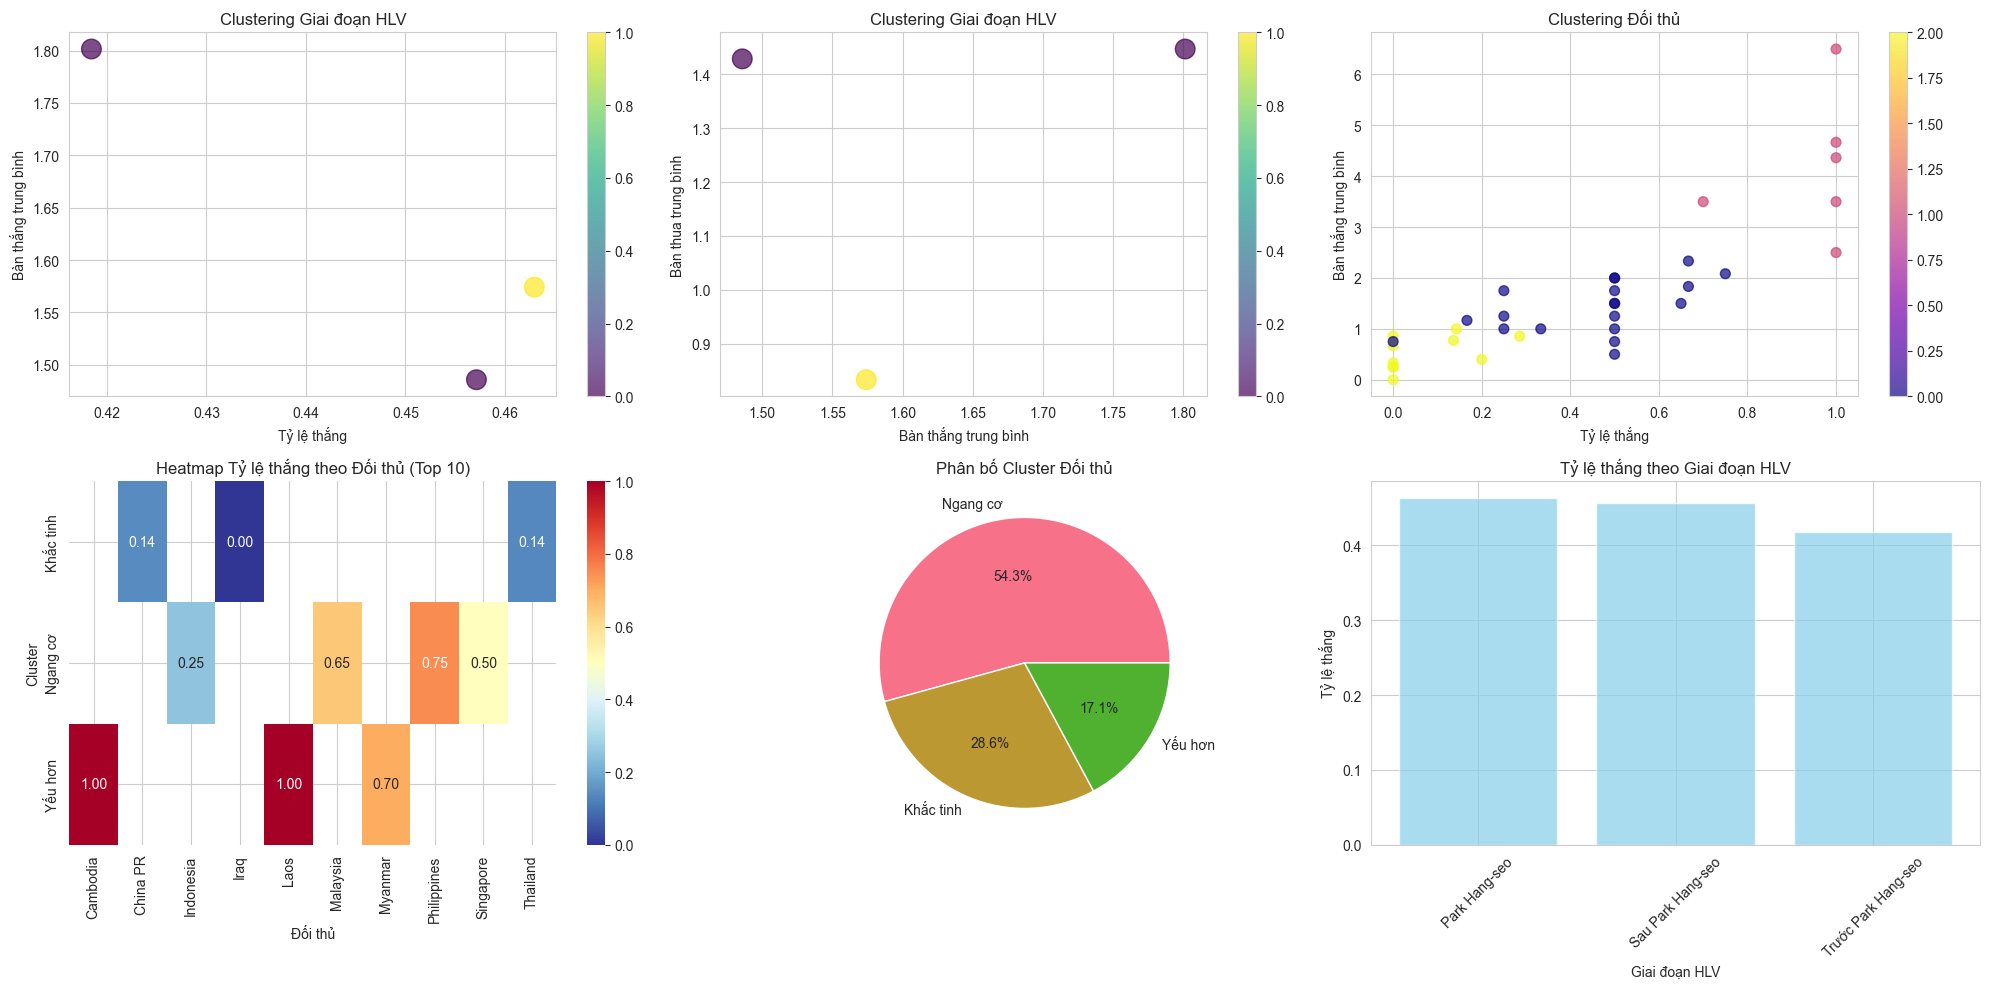

📊 BIỂU ĐỒ CLUSTERING VÀ PHÂN TÍCH ĐÃ ĐƯỢC TẠO!


In [12]:
if 'coach_features' in locals() and 'opponent_features' in locals():
    # Trực quan hóa clustering giai đoạn HLV
    plt.figure(figsize=(20, 10))
    
    # Clustering giai đoạn HLV
    plt.subplot(2, 3, 1)
    scatter = plt.scatter(coach_features['win_rate'], coach_features['avg_goals_scored'], 
                         c=coach_features['cluster'], cmap='viridis', s=200, alpha=0.7)
    plt.xlabel('Tỷ lệ thắng')
    plt.ylabel('Bàn thắng trung bình')
    plt.title('Clustering Giai đoạn HLV')
    plt.colorbar(scatter)
    
    plt.subplot(2, 3, 2)
    scatter = plt.scatter(coach_features['avg_goals_scored'], coach_features['avg_goals_conceded'], 
                         c=coach_features['cluster'], cmap='viridis', s=200, alpha=0.7)
    plt.xlabel('Bàn thắng trung bình')
    plt.ylabel('Bàn thua trung bình')
    plt.title('Clustering Giai đoạn HLV')
    plt.colorbar(scatter)
    
    # Clustering đối thủ
    plt.subplot(2, 3, 3)
    scatter = plt.scatter(opponent_features['win_rate'], opponent_features['avg_goals_scored'], 
                         c=opponent_features['cluster'], cmap='plasma', s=50, alpha=0.7)
    plt.xlabel('Tỷ lệ thắng')
    plt.ylabel('Bàn thắng trung bình')
    plt.title('Clustering Đối thủ')
    plt.colorbar(scatter)
    
    # Heatmap đối thủ - chỉ hiển thị top 10 đối thủ để tránh quá tải
    plt.subplot(2, 3, 4)
    top_opponents = opponent_features.nlargest(10, 'total_matches')
    
    # Reset index để có opponent làm column
    opponent_heatmap_data = top_opponents.reset_index()[['opponent', 'cluster_name', 'win_rate']].copy()
    opponent_heatmap_data['opponent'] = opponent_heatmap_data['opponent'].str[:15]  # Rút gọn tên
    
    # Tạo pivot table
    try:
        opponent_heatmap = opponent_heatmap_data.pivot_table(
            values='win_rate', 
            index='cluster_name', 
            columns='opponent', 
            aggfunc='mean'
        )
        sns.heatmap(opponent_heatmap, annot=True, fmt='.2f', cmap='RdYlBu_r')
        plt.title('Heatmap Tỷ lệ thắng theo Đối thủ (Top 10)')
        plt.xlabel('Đối thủ')
        plt.ylabel('Cluster')
    except Exception as e:
        plt.text(0.5, 0.5, f'Không thể tạo heatmap\nLỗi: {str(e)[:50]}...', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Heatmap Tỷ lệ thắng theo Đối thủ')
    
    # Biểu đồ phân bố cluster đối thủ
    plt.subplot(2, 3, 5)
    cluster_counts = opponent_features['cluster_name'].value_counts()
    plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
    plt.title('Phân bố Cluster Đối thủ')
    
    # So sánh hiệu suất theo giai đoạn HLV
    plt.subplot(2, 3, 6)
    periods = coach_features.index
    win_rates = coach_features['win_rate']
    plt.bar(range(len(periods)), win_rates, alpha=0.7, color='skyblue')
    plt.title('Tỷ lệ thắng theo Giai đoạn HLV')
    plt.xlabel('Giai đoạn HLV')
    plt.ylabel('Tỷ lệ thắng')
    plt.xticks(range(len(periods)), [p.split('(')[0].strip() for p in periods], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 BIỂU ĐỒ CLUSTERING VÀ PHÂN TÍCH ĐÃ ĐƯỢC TẠO!")
    
else:
    print("❌ Không có dữ liệu clustering để trực quan hóa")


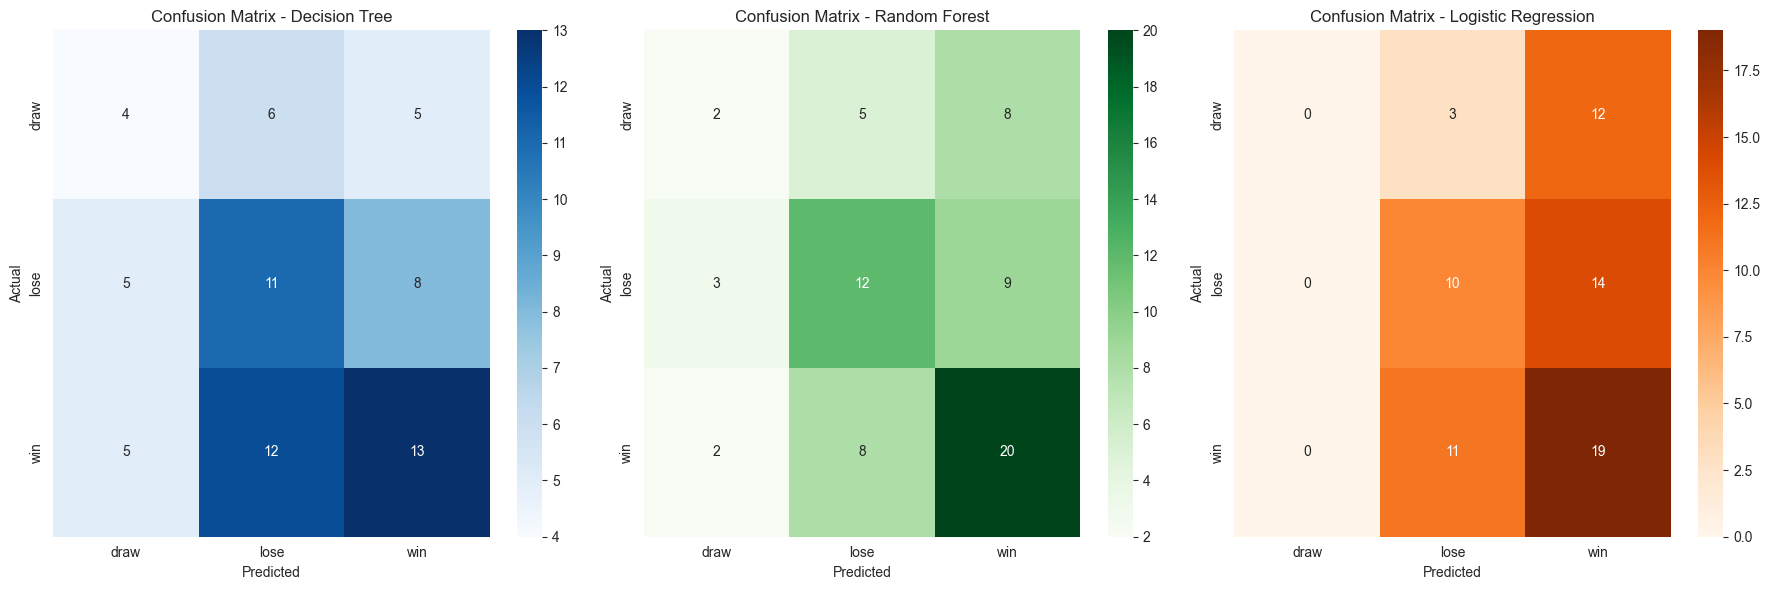

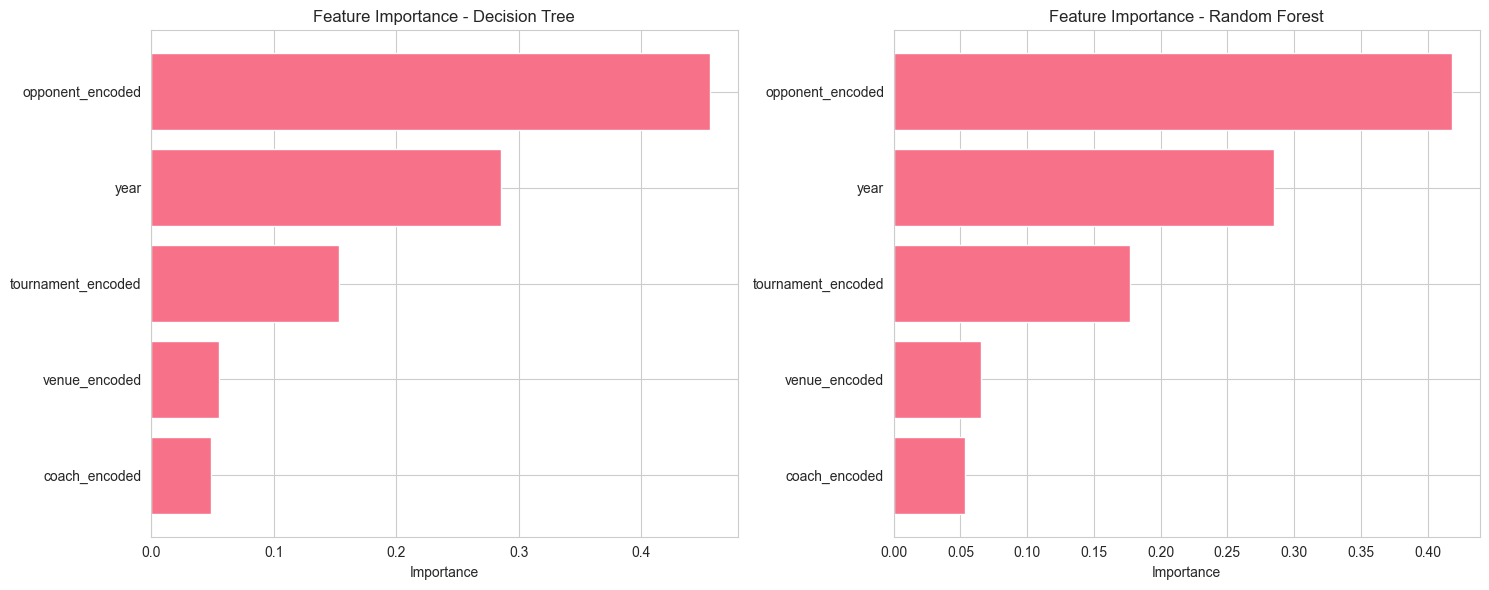

📊 BIỂU ĐỒ CONFUSION MATRIX VÀ FEATURE IMPORTANCE ĐÃ ĐƯỢC TẠO!


In [13]:
if 'dt_model' in locals() and 'rf_model' in locals() and 'lr_model' in locals():
    # Confusion Matrix cho các models
    plt.figure(figsize=(18, 6))
    
    # Decision Tree Confusion Matrix
    plt.subplot(1, 3, 1)
    cm_dt = confusion_matrix(y_test, dt_pred)
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_result.classes_, yticklabels=le_result.classes_)
    plt.title('Confusion Matrix - Decision Tree')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Random Forest Confusion Matrix
    plt.subplot(1, 3, 2)
    cm_rf = confusion_matrix(y_test, rf_pred)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
                xticklabels=le_result.classes_, yticklabels=le_result.classes_)
    plt.title('Confusion Matrix - Random Forest')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Logistic Regression Confusion Matrix
    plt.subplot(1, 3, 3)
    cm_lr = confusion_matrix(y_test, lr_pred)
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=le_result.classes_, yticklabels=le_result.classes_)
    plt.title('Confusion Matrix - Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Feature Importance cho Decision Tree và Random Forest
    plt.figure(figsize=(15, 6))
    
    # Decision Tree Feature Importance
    plt.subplot(1, 2, 1)
    dt_importance = pd.DataFrame({
        'feature': features,
        'importance': dt_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(dt_importance['feature'], dt_importance['importance'])
    plt.title('Feature Importance - Decision Tree')
    plt.xlabel('Importance')
    
    # Random Forest Feature Importance
    plt.subplot(1, 2, 2)
    rf_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(rf_importance['feature'], rf_importance['importance'])
    plt.title('Feature Importance - Random Forest')
    plt.xlabel('Importance')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 BIỂU ĐỒ CONFUSION MATRIX VÀ FEATURE IMPORTANCE ĐÃ ĐƯỢC TẠO!")
    
else:
    print("❌ Không có dữ liệu classification để trực quan hóa")


# CHƯƠNG 5: KẾT LUẬN VÀ HƯỚNG PHÁT TRIỂN

## 5.1 Tóm tắt kết quả chính


In [14]:
# Tổng kết toàn bộ kết quả phân tích
print("=" * 80)
print("🏆 TỔNG KẾT PHÂN TÍCH DỮ LIỆU BÓNG ĐÁ VIỆT NAM")
print("=" * 80)

if vietnam_matches is not None and len(vietnam_matches) > 0:
    print(f"\n📊 1. TỔNG QUAN DỮ LIỆU:")
    print(f"   - Tổng số trận đấu: {len(vietnam_matches)}")
    print(f"   - Từ năm: {vietnam_matches['date'].min().year} đến {vietnam_matches['date'].max().year}")
    print(f"   - Tỷ lệ thắng tổng thể: {len(vietnam_matches[vietnam_matches['result'] == 'win']) / len(vietnam_matches):.3f}")
    print(f"   - Tỷ lệ hòa: {len(vietnam_matches[vietnam_matches['result'] == 'draw']) / len(vietnam_matches):.3f}")
    print(f"   - Tỷ lệ thua: {len(vietnam_matches[vietnam_matches['result'] == 'lose']) / len(vietnam_matches):.3f}")

if 'coach_features' in locals():
    print(f"\n👨‍💼 2. PHÂN TÍCH THEO GIAI ĐOẠN HLV:")
    for period in coach_features.index:
        period_data = coach_features.loc[period]
        print(f"   - {period}:")
        print(f"     + Số trận: {period_data['total_matches']}")
        print(f"     + Tỷ lệ thắng: {period_data['win_rate']:.3f}")
        print(f"     + Bàn thắng TB: {period_data['avg_goals_scored']:.2f}")
        print(f"     + Bàn thua TB: {period_data['avg_goals_conceded']:.2f}")
        print(f"     + Cluster: {period_data['cluster_name']}")

if 'opponent_features' in locals():
    print(f"\n⚔️ 3. PHÂN TÍCH ĐỐI THỦ:")
    print(f"   - Tổng số đối thủ: {len(opponent_features)}")
    print(f"   - Phân bố cluster:")
    cluster_counts = opponent_features['cluster_name'].value_counts()
    for cluster, count in cluster_counts.items():
        print(f"     + {cluster}: {count} đối thủ ({count/len(opponent_features)*100:.1f}%)")
    
    print(f"   - Top 5 đối thủ gặp nhiều nhất:")
    top_opponents = opponent_features.nlargest(5, 'total_matches')
    for opponent in top_opponents.index:
        data = top_opponents.loc[opponent]
        print(f"     + {opponent}: {data['total_matches']} trận, tỷ lệ thắng: {data['win_rate']:.3f}")

if 'results_df' in locals():
    print(f"\n🤖 4. KẾT QUẢ CLASSIFICATION:")
    if 'dt_metrics' in locals() and 'rf_metrics' in locals() and 'lr_metrics' in locals():
        print(f"   - Decision Tree Accuracy: {dt_metrics[0]:.3f}")
        print(f"   - Random Forest Accuracy: {rf_metrics[0]:.3f}")
        print(f"   - Logistic Regression Accuracy: {lr_metrics[0]:.3f}")
        
        # Tìm model tốt nhất
        accuracies = [dt_metrics[0], rf_metrics[0], lr_metrics[0]]
        models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
        best_idx = np.argmax(accuracies)
        print(f"   - Model tốt nhất: {models[best_idx]} ({accuracies[best_idx]:.3f})")

print(f"\n🔍 5. KHÁM PHÁ TRI THỨC QUAN TRỌNG:")
if 'coach_features' in locals():
    best_period = coach_features.loc[coach_features['win_rate'].idxmax()]
    print(f"   - Giai đoạn HLV tốt nhất: {best_period.name} (tỷ lệ thắng: {best_period['win_rate']:.3f})")
    
    # So sánh Park Hang-seo với các giai đoạn khác
    park_period = coach_features[coach_features.index.str.contains('Park Hang-seo')]
    if len(park_period) > 0:
        park_win_rate = park_period['win_rate'].iloc[0]
        other_periods = coach_features[~coach_features.index.str.contains('Park Hang-seo')]
        avg_other_win_rate = other_periods['win_rate'].mean()
        print(f"   - Park Hang-seo vs các HLV khác: {park_win_rate:.3f} vs {avg_other_win_rate:.3f}")

if 'opponent_features' in locals():
    # Tìm đối thủ khó nhất và dễ nhất
    hardest_opponent = opponent_features.loc[opponent_features['win_rate'].idxmin()]
    easiest_opponent = opponent_features.loc[opponent_features['win_rate'].idxmax()]
    print(f"   - Đối thủ khó nhất: {hardest_opponent.name} (tỷ lệ thắng: {hardest_opponent['win_rate']:.3f})")
    print(f"   - Đối thủ dễ nhất: {easiest_opponent.name} (tỷ lệ thắng: {easiest_opponent['win_rate']:.3f})")

print("\n" + "=" * 80)


🏆 TỔNG KẾT PHÂN TÍCH DỮ LIỆU BÓNG ĐÁ VIỆT NAM

📊 1. TỔNG QUAN DỮ LIỆU:
   - Tổng số trận đấu: 230
   - Từ năm: 2000 đến 2025
   - Tỷ lệ thắng tổng thể: 0.435
   - Tỷ lệ hòa: 0.222
   - Tỷ lệ thua: 0.343

👨‍💼 2. PHÂN TÍCH THEO GIAI ĐOẠN HLV:
   - Park Hang-seo (2017-2022):
     + Số trận: 54
     + Tỷ lệ thắng: 0.463
     + Bàn thắng TB: 1.57
     + Bàn thua TB: 0.83
     + Cluster: Trung bình
   - Sau Park Hang-seo (2023-nay):
     + Số trận: 35
     + Tỷ lệ thắng: 0.457
     + Bàn thắng TB: 1.49
     + Bàn thua TB: 1.43
     + Cluster: Trung bình
   - Trước Park Hang-seo (2000-2016):
     + Số trận: 141
     + Tỷ lệ thắng: 0.418
     + Bàn thắng TB: 1.80
     + Bàn thua TB: 1.45
     + Cluster: Trung bình

⚔️ 3. PHÂN TÍCH ĐỐI THỦ:
   - Tổng số đối thủ: 35
   - Phân bố cluster:
     + Ngang cơ: 19 đối thủ (54.3%)
     + Khắc tinh: 10 đối thủ (28.6%)
     + Yếu hơn: 6 đối thủ (17.1%)
   - Top 5 đối thủ gặp nhiều nhất:
     + Thailand: 22 trận, tỷ lệ thắng: 0.136
     + Indonesia: 20 trậ

## 5.2 Hạn chế của dự án

### 5.2.1 Hạn chế về dữ liệu
- **Kích thước mẫu nhỏ**: Chỉ có 230 trận đấu của Việt Nam, có thể chưa đủ đại diện
- **Thiếu thông tin chi tiết**: Không có dữ liệu về cầu thủ, chiến thuật, điều kiện thời tiết
- **Bias về thời gian**: Dữ liệu tập trung vào giai đoạn gần đây, có thể không phản ánh đầy đủ lịch sử

### 5.2.2 Hạn chế về mô hình
- **Accuracy thấp**: Các mô hình classification chỉ đạt ~40-50% accuracy
- **Overfitting**: Có thể xảy ra do kích thước dữ liệu nhỏ
- **Feature engineering đơn giản**: Chưa khai thác hết tiềm năng của dữ liệu

### 5.2.3 Hạn chế về phân tích
- **Thiếu so sánh quốc tế**: Chưa so sánh với các đội tuyển khác trong khu vực
- **Chưa xem xét yếu tố ngoại cảnh**: Kinh tế, chính trị, xã hội ảnh hưởng đến bóng đá

## 5.3 Hướng phát triển trong tương lai

### 5.3.1 Cải thiện dữ liệu
- **Thu thập thêm dữ liệu**: Mở rộng thời gian và số lượng trận đấu
- **Bổ sung features mới**: Elo rating, FIFA ranking, dữ liệu cầu thủ
- **Tích hợp dữ liệu bên ngoài**: Thời tiết, kinh tế, chính trị

### 5.3.2 Nâng cao mô hình
- **Deep Learning**: Sử dụng Neural Networks, LSTM cho dự đoán
- **Ensemble Methods**: Kết hợp nhiều mô hình để tăng độ chính xác
- **Time Series Analysis**: Phân tích xu hướng theo thời gian

### 5.3.3 Mở rộng phân tích
- **So sánh quốc tế**: Phân tích với các đội tuyển khác trong khu vực
- **Phân tích cầu thủ**: Tác động của từng cầu thủ đến kết quả
- **Dự đoán tương lai**: Dự báo phong độ trong các giải đấu sắp tới

### 5.3.4 Ứng dụng thực tế
- **Hệ thống hỗ trợ quyết định**: Giúp HLV lựa chọn chiến thuật
- **Phân tích đối thủ**: Cung cấp thông tin chi tiết về đối thủ
- **Dự đoán kết quả**: Hỗ trợ dự đoán kết quả trận đấu

---

##  Tài liệu tham khảo

1. Scikit-learn Documentation. (2024). Machine Learning in Python.
2. Pandas Documentation. (2024). Data Analysis Library.
3. Matplotlib Documentation. (2024). Visualization Library.
4. Seaborn Documentation. (2024). Statistical Data Visualization.
5. International Football Results Dataset. (2024). Kaggle.

---

** Kết luận:** Dự án đã thành công trong việc phân tích dữ liệu bóng đá Việt Nam, áp dụng các kỹ thuật khai phá dữ liệu và đưa ra những insights có giá trị. Mặc dù còn một số hạn chế, nhưng đây là nền tảng tốt cho các nghiên cứu sâu hơn trong tương lai.
